In [7]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import utils
from tensorflow.keras.layers import Conv2D, MaxPool2D, Conv2DTranspose
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras import backend as K
import pydot
import graphviz

# the size of the images in the PCAM dataset
IMAGE_SIZE = 96


In [8]:
def get_pcam_generators(base_dir, train_batch_size=32, val_batch_size=32, class_mode='binary'):

     # dataset parameters
     TRAIN_PATH = os.path.join(base_dir, 'train+val', 'train')
     VALID_PATH = os.path.join(base_dir, 'train+val', 'valid')

     RESCALING_FACTOR = 1./255
     
     # instantiate data generators
     datagen = ImageDataGenerator(rescale=RESCALING_FACTOR)

     train_gen = datagen.flow_from_directory(TRAIN_PATH,
                                             target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                             batch_size=train_batch_size,
                                             class_mode=class_mode)

     val_gen = datagen.flow_from_directory(VALID_PATH,
                                             target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                             batch_size=val_batch_size,
                                             class_mode=class_mode,
                                             shuffle=False)
     
     return train_gen, val_gen

In [14]:
train_gen, val_gen = get_pcam_generators('../', class_mode="input")

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


<p>The class below contains all functions that are needed to create the autoencoder. I found two ways to easily create a convolutional autoencoder with the Keras API. In the code below you can find the first way in the function "create_autoencoder_v1" and the second way in the "create_autoencoder_v2" </p>

In [10]:

class autoencoder(Sequential):
    def __init__(self):
        super().__init__()
        self.add(Input(shape=(96,96,3)))

    def create_autoencoder_v1(self, layers = 1):
        for i in range(layers):
            self.add(Conv2D(64, (3,3), activation='relu', padding='same'))
            self.add(MaxPool2D((2,2), padding='same'))

            self.add(Conv2D(32, (3,3), activation='relu', padding='same'))
            self.add(MaxPool2D((2,2), padding='same'))

            self.add(Conv2D(32, (3,3), activation='relu', padding='same'))
            self.add(MaxPool2D((2,2), padding='same'))

            self.add(Conv2D(32, (3,3), activation='relu', padding='same'))
            self.add(UpSampling2D((2,2)))

            self.add(Conv2D(32, (3,3), activation='relu', padding='same'))
            self.add(UpSampling2D((2,2)))
            
            self.add(Conv2D(64, (3,3), activation='relu', padding='same'))
            self.add(UpSampling2D((2,2)))

    def create_autoencoder_v2(self, layers = 1):
        for i in range(layers):
            self.add(Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(96,96,3)))
            self.add(MaxPool2D((2,2), padding='same'))
        
            self.add(Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(96,96,3), name='encoder'))
            self.add(MaxPool2D((2,2), padding='same'))

            self.add(Conv2DTranspose(64, (3,3),strides=2 ,activation='relu', padding='same'))
            self.add(Conv2DTranspose(64, (3,3),strides=2 ,activation='relu', padding='same'))


    def compile_model(self):
        self.add(Conv2D(3, (3,3), activation='sigmoid', padding='same'))
        self.compile(optimizer='adam', loss='mean_squared_error')
    
model1 = autoencoder()
model1.create_autoencoder_v2()
model1.compile_model()
model1._name = 'model1'


<p> Overview of the current model </p>

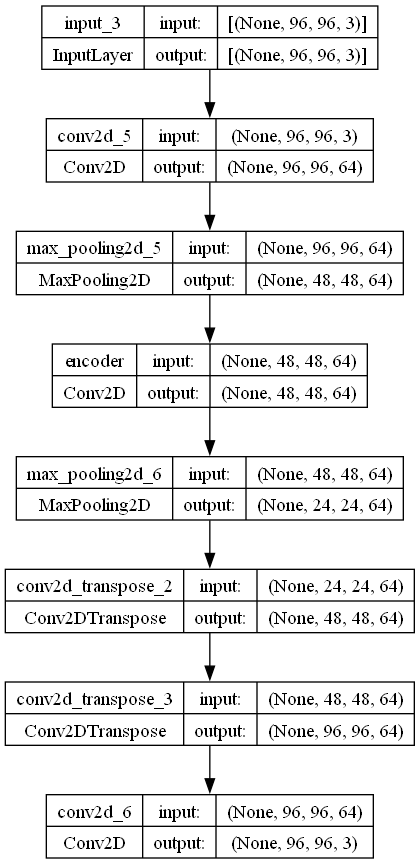

In [12]:
#for layer in model1.layers:
#    print(layer.output_shape)
utils.plot_model(model1, show_shapes=True, show_layer_names=True, to_file='model1.png')

<p>Training model with code copied from the cnn assignment, small adjustments to this code were made. Such as adding a "shuffle" fucntion to the training</p>

In [15]:
# save the model and weights
model_name = 'my_first_cnn_model'
model_filepath = model_name + '.json'
weights_filepath = model_name + '_weights.hdf5'

model_json = model1.to_json() # serialize model to JSON
with open(model_filepath, 'w') as json_file:
    json_file.write(model_json) 


# define the model checkpoint and Tensorboard callbacks
checkpoint = ModelCheckpoint(weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
tensorboard = TensorBoard(os.path.join('logs', model_name))
callbacks_list = [checkpoint, tensorboard]


# train the model
train_steps = train_gen.n//train_gen.batch_size
val_steps = val_gen.n//val_gen.batch_size

history = model1.fit(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=1,
                    shuffle=True,
                    callbacks=callbacks_list)

4500/4500 [==============================] - ETA: 0s - loss: 0.0085
Epoch 1: val_loss improved from inf to 0.00567, saving model to my_first_cnn_model_weights.hdf5
4500/4500 [==============================] - 1086s 241ms/step - loss: 0.0085 - val_loss: 0.0057


<p>Checking autoencoder performance by showing real image (left) and predicted image (right) <p>

1/1 [==============================] - 0s 125ms/step


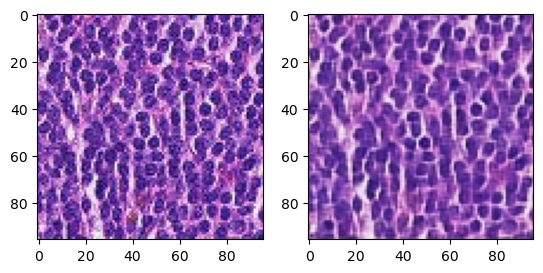

In [ ]:
path = "../train+val/valid/0"
names = os.listdir(path)
#true_test = plt.imread(path + "/" + names[6])
predict_test =  model1.predict(train_gen[1][1])
image = 6
fig, ax = plt.subplots(1,2)
ax[0].imshow(train_gen[1][1][image])
ax[1].imshow(predict_test[image])

In [18]:
latent_space = model1.get_layer("encoder").get_weights()[0]
latent_space.shape

(3, 3, 64, 64)

In [19]:
train_gen, val_gen = get_pcam_generators('../', class_mode="binary")

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


In [26]:
class CNN(Sequential):
    def __init__(self):
        super().__init__()
        self.add(Input(shape=(96,96,3)))
        
        
    
    def create_cnn(self):
        self.add(Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(96,96,3)))
        self.add(MaxPool2D((2,2), padding='same'))
    
        self.add(Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(96,96,3), name='encoder'))
        self.add(MaxPool2D((2,2), padding='same'))
        
        
        self.add(Conv2D(128, (3,3), activation='relu', padding='same'))
        self.add(MaxPool2D((2,2), padding='same'))

        self.add(Conv2D(1, (12,12), activation='relu', padding='valid'))
        self.add(Conv2D(1, (1,1), activation='relu', padding='same'))
        self.add(GlobalAveragePooling2D())

    def compile_model(self):
        self.compile(SGD(learning_rate=0.01, momentum=0.95), loss='binary_crossentropy', metrics=['accuracy'])

    


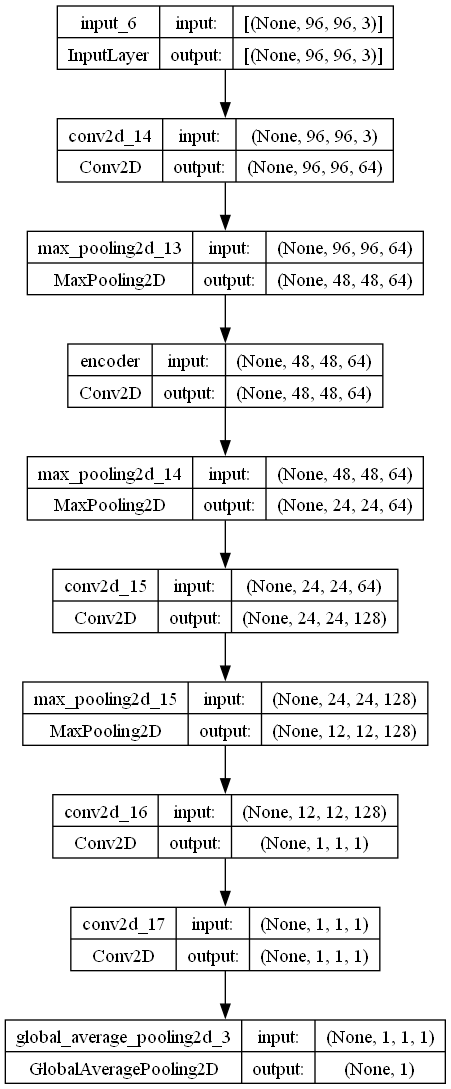

In [27]:
model2 = CNN()
model2.create_cnn()
model2.get_layer("encoder").set_weights(model1.get_layer("encoder").get_weights()) #Get weights from latent space from autoencoder model 
model2.compile_model()
utils.plot_model(model2, show_shapes=True, show_layer_names=True, to_file='model1.png')
#model2.summary()

In [28]:
# save the model and weights
model_name = 'my_first_cnn_model'
model_filepath = model_name + '.json'
weights_filepath = model_name + '_weights.hdf5'

model_json = model2.to_json() # serialize model to JSON
with open(model_filepath, 'w') as json_file:
    json_file.write(model_json) 


# define the model checkpoint and Tensorboard callbacks
checkpoint = ModelCheckpoint(weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
tensorboard = TensorBoard(os.path.join('logs', model_name))
callbacks_list = [checkpoint, tensorboard]


# train the model
train_steps = train_gen.n//train_gen.batch_size
val_steps = val_gen.n//val_gen.batch_size



history = model2.fit(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=3,
                    shuffle=True,
                    callbacks=callbacks_list)

Epoch 1/3
1456/4500 [========>.....................] - ETA: 10:06 - loss: 7.6949 - accuracy: 0.5011

KeyboardInterrupt: 